## **Blood cell image classification for malaria detection**







In 2019, malaria caused an estimated 229 million clinical episodes,
and **409,000 deaths**.</br> 
Malaria parasites can be identified by examining under the microscope a drop of the patient’s blood. Prior to examination, the specimen is stained (most often with the Giemsa stain) to give the parasites a distinctive appearance.
which is usually repetetive and tidious task to perform.

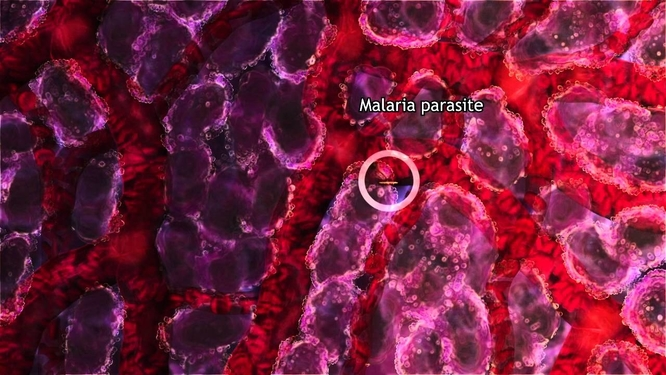

So, in this workshop we will use some "AI" magic and perform the classification of **blood cells** into **parasitized** with malaria or **not infected** automatically in order to facilitate malaria diagnosis.

## **import necessary packages**


In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
# useful for building neural networks then interacting with

import os
# useful for manipulating folders and files

import cv2
from PIL import Image
# to manipulate images


import numpy as np
np.random.seed(1000)# for results reproduceability
# useful for manipulating matrix and multidimensional arrays

import matplotlib.pyplot as plt
# useful for plotting and showing  images

## **Loading Dataset**


In order to train our model, we will use a dataset of segmented cells from the thin blood smear slide images from the Malaria Screener research activity.</br>
Images belong to two types cells: parasitized with malaria and not infected. 
This the link to the full description of the dataset and how it was collected:
https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html

In [2]:
#we verify that our dataset is balanced
print("number of parasited cells images= ",len(os.listdir(r"..\Dataset\Train\dataset_part1\Parasitized")))
print("number of uninfected cells images=  ",len(os.listdir(r"..\Dataset\Train\dataset_part1\Uninfected")))

number of parasited cells images=  101
number of uninfected cells images=   101


In [3]:
image_directory = r'..\Dataset\Train\dataset_part1'
SIZE = 64  # our neural nets expect input data of same format so we will use resize our images to (size x size) 
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

**a) Loading Parasitized cells**

In [4]:
parasitized_images = os.listdir(os.path.join(image_directory, 'Parasitized/'))
uninfected_images = os.listdir(os.path.join(image_directory, 'Uninfected/'))

for i, (image_name_parasited,image_name_uninfected) in enumerate(zip(parasitized_images,uninfected_images)):
    # go through all files in both folders simultanuously
    if ('.png' in image_name_parasited) and ('.png' in image_name_uninfected):
        image_parasited = Image.open(os.path.join(image_directory, 'Parasitized', image_name_parasited))
        image_uninfected = Image.open(os.path.join(image_directory, 'Uninfected', image_name_uninfected))
        image_parasited = image_parasited.resize((SIZE, SIZE))
        image_uninfected = image_uninfected.resize((SIZE, SIZE))
        dataset.append(np.array(image_parasited))
        label.append(0)
        dataset.append(np.array(image_uninfected))
        label.append(1)
        

**b) Visualising a blood cell image**

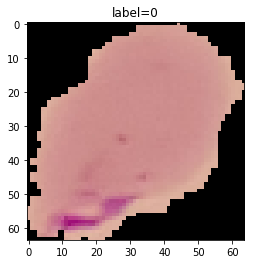

In [5]:
# we have now two list where at index i : dataset contains the image pixel values, label contains its label (class)
plt.title("label="+str(label[0]))
plt.imshow(dataset[0])
#plt.show()


**Splitting data into training and test**

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # transforms labels from a number to 1-D array of 0s and 1s 

# we will split our **dataset** and its corresponding labels to two parts:
#80% will be used to train our model, and 20% will be used to test how good our trained model is. 
X_train, X_test, y_train, y_test = train_test_split(np.array(dataset), to_categorical(np.array(label)), test_size = 0.10, random_state = 0)


 # **Building the model**

In [7]:
INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3) as all input images must have the same shape

In [8]:
# our deep neural network contains convolutional layers, maxpooling layers
# and BatchNormalisation and dropout layers to deal with overfitting (not genralizing on unseen data )

model = None
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Convolution2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(activation = 'relu', units=512))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(activation = 'relu', units=256))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(activation = 'sigmoid', units=2))
 

In [9]:
# we compile our model 
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [10]:
# this is a summary of our DNN
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        1

# **Training the model**

In [11]:
## Training the model
#Fit the model
history = model.fit(X_train, 
                         y_train, 
                         batch_size = 32, 
                         verbose = 1, 
                         epochs = 10,      
                         validation_split = 0.1,
                         shuffle = True
                     )


Train on 162 samples, validate on 18 samples
Epoch 1/10
162/162 [==============================] - 3s 19ms/sample - loss: 0.4549 - accuracy: 0.7778 - val_loss: 1.3327 - val_accuracy: 0.7778
Epoch 2/10
162/162 [==============================] - 0s 422us/sample - loss: 0.1945 - accuracy: 0.9568 - val_loss: 7.1636 - val_accuracy: 0.5556
Epoch 3/10
162/162 [==============================] - 0s 400us/sample - loss: 0.1169 - accuracy: 0.9753 - val_loss: 7.1636 - val_accuracy: 0.5556
Epoch 4/10
162/162 [==============================] - 0s 393us/sample - loss: 0.1436 - accuracy: 0.9383 - val_loss: 7.1636 - val_accuracy: 0.5556
Epoch 5/10
162/162 [==============================] - 0s 400us/sample - loss: 0.1249 - accuracy: 0.9506 - val_loss: 7.1636 - val_accuracy: 0.5556
Epoch 6/10
162/162 [==============================] - 0s 383us/sample - loss: 0.0759 - accuracy: 0.9815 - val_loss: 7.1636 - val_accuracy: 0.5556
Epoch 7/10
162/162 [==============================] - 0s 377us/sample - loss: 0.

# **Testing the model**

In [12]:
# ## Accuracy calculation
# 
# now we calculate the accuracy on the test data.

print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

20/20 [==============================] - 0s 15ms/sample - loss: 5.7862 - accuracy: 0.6000
Test_Accuracy: 60.00%


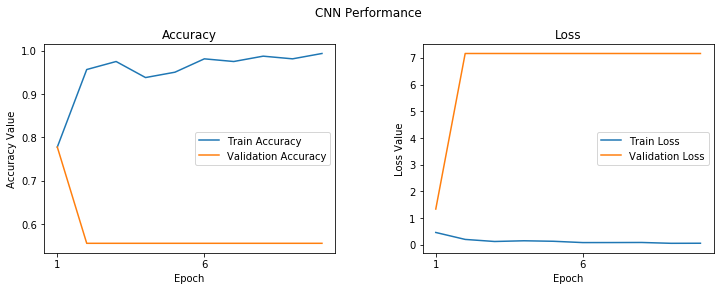

In [13]:
# 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")